In [2]:
import numpy as np
import scipy
from scipy import stats

import pymc3 as pm

import arviz as az
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import ipywidgets as ipyw

In [10]:
# Define colors 
viridish = [(0.2823529411764706, 0.11372549019607843, 0.43529411764705883, 1.0),
            (0.1450980392156863, 0.6705882352941176, 0.5098039215686274, 1.0),
            (0.6901960784313725, 0.8666666666666667, 0.1843137254901961, 1.0)]

# Bayesian modeling notes

These notebooks consist of my notes, codes and solutions to exercises from the book ["Bayesian modeling and computation in Python" (Martin et al., 2022)](https://bayesiancomputationbook.com/welcome.html)


# Exploratory Analysis of Bayesian Models



## Diagnosing numerical inference

Monte Carlo Markov Chains ([**MCMC**](https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo)) diagnosis.

Good **MCMC** chain should ideally resemble an $iid$ sample. 

### Divergences 

**Divergences** appear in Hamiltonian Monte Carlo methods and are a useful diagnostic. 

First, let's build a poorly specified model:

In [4]:
with pm.Model() as model_0:
    theta_0 = pm.Normal('theta_1', 0, 1, testval=.1)
    theta_1 = pm.Uniform('theta_2', -theta_0, theta_0)
    inference_data_0 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_2, theta_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 45 seconds.
There were 551 divergences after tuning. Increase `target_accept` or reparameterize.
There were 659 divergences after tuning. Increase `target_accept` or reparameterize.
There were 628 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8859438833594632, but should be close to 0.8. Try to increase the number of tuning steps.
There were 567 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


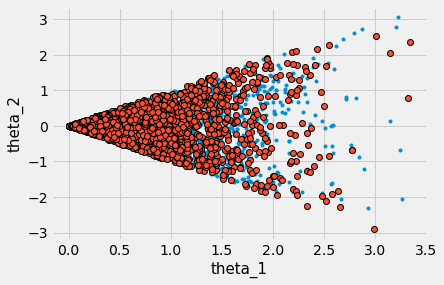

In [7]:
az.plot_pair(inference_data_0, divergences=True)
plt.show()

Red dots mark divergences in HMC. We see a lot of them here.

As `theta_0` is modeled using normal distribution, it might take negative values. This does not make sense in the context of our parametrization of `Uniform`.

Let's fix it:

In [9]:
with pm.Model() as model_1:
    theta_0 = pm.HalfNormal('theta_1', 1 / (1 - 2 / np.pi)**.5)
    theta_1 = pm.Uniform('theta_2', -theta_0, theta_0)
    inference_data_1 = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_2, theta_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.


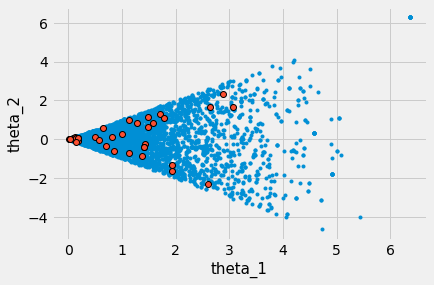

In [10]:
az.plot_pair(inference_data_1, divergences=True)
plt.show()

This looks much better! Let's try to change the acceptance probability to improve it further!

In [11]:
with pm.Model() as model_2:
    theta_0 = pm.HalfNormal('theta_1', 1 / (1 - 2 / np.pi)**.5)
    theta_1 = pm.Uniform('theta_2', -theta_0, theta_0)
    inference_data_2 = pm.sample(return_inferencedata=True, target_accept=.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_2, theta_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 38 seconds.


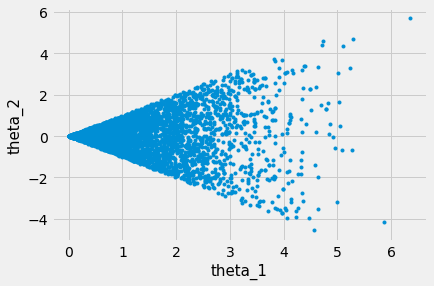

In [12]:
az.plot_pair(inference_data_2, divergences=True)
plt.show()

This one looks pretty amazing! ❤️

Let's compare traces and divergences!

In [17]:
inference_datas = [
    inference_data_0,
    inference_data_1,
    inference_data_2
]

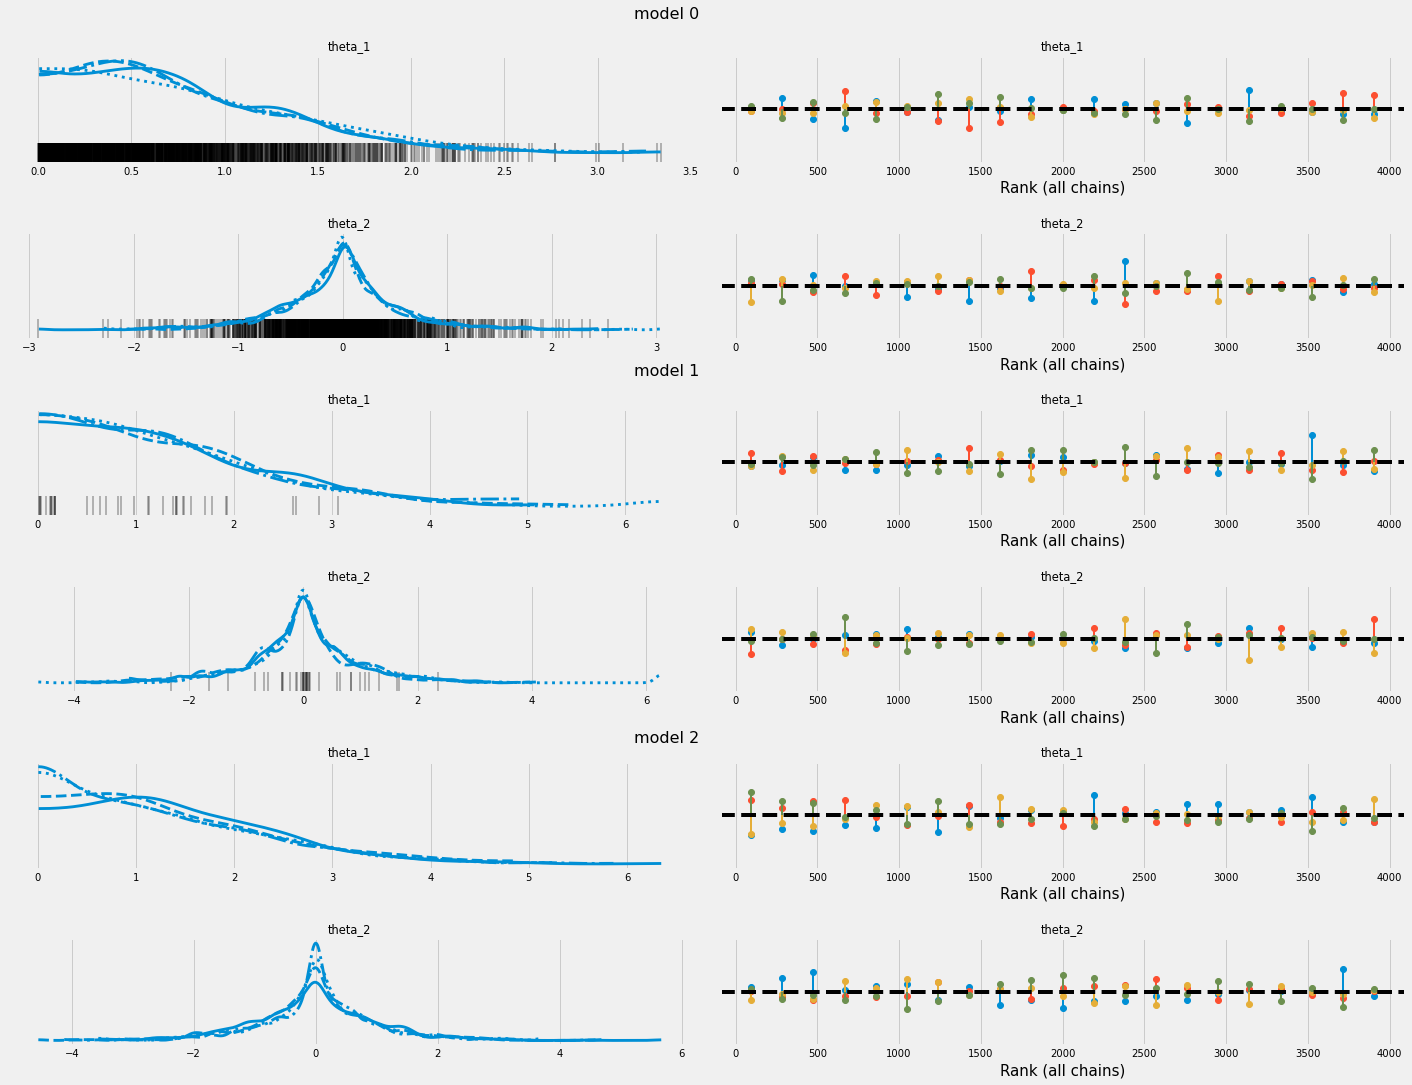

In [30]:
fig, axes = plt.subplots(6, 2, figsize=(20, 15))

axes = axes.reshape(3, 2, 2)
for idata, ax, color in zip(inference_datas, axes, ["0.95", "1", "0.95"]):
    az.plot_trace(idata, kind="rank_vlines", axes=ax)
#     [ax_.set_facecolor(color) for ax_ in ax.ravel()]
fig.text(0.45, 1, s="model 0", fontsize=16)
fig.text(0.45, 0.67, s="model 1", fontsize=16)
fig.text(0.45, 0.33, s="model 2", fontsize=16)

fig.tight_layout(pad=1.5)
plt.show()

Black bars on the left are divergences. On the left, we see a v-line rank plot (flat is perfect).

## Model comparison

Generate data:

In [33]:
# N(0, 1); n = 100
y_obs = np.random.normal(0, 1, size=100)

Create 3 different models: 

In [35]:
# Collect inference data
inference_datas = {}


# Model A
with pm.Model() as model_A:
    # Params
    sigma = pm.HalfNormal('sigma', 1)
    y = pm.SkewNormal('y', 0, sigma, alpha=1, observed=y_obs)
    
    # Inference data
    inference_data_A = pm.sample(return_inferencedata=True)
    inference_data_A.add_groups(
        {'posterior_predictive': {
            'y': pm.sample_posterior_predictive(inference_data_A)['y'][None, :]}})
    
    # Store inferernce data
    inference_datas['model_A'] = inference_data_A
    
    
# Model B
with pm.Model() as model_B:  
    # Params
    sigma = pm.HalfNormal('sigma', 1)
    y = pm.Normal('y', 0, sigma, observed=y_obs)
    
    # Inference data
    inference_data_B = pm.sample(return_inferencedata=True)
    inference_data_B.add_groups(
        {'posterior_predictive': {
            'y': pm.sample_posterior_predictive(inference_data_B)['y'][None, :]}})
    
    # Store inferernce data
    inference_datas['model_B'] = inference_data_B
    
    
# Model C
with pm.Model() as model_C:
    # Params
    mu = pm.Normal('mu', 0, 1)
    sigma = pm.HalfNormal('sigma', 1)
    y = pm.Normal('y', mu, sigma, observed=y_obs)
    
    # Inference data
    inference_data_C = pm.sample(return_inferencedata=True)
    inference_data_C.add_groups(
        {'posterior_predictive': {
            'y': pm.sample_posterior_predictive(inference_data_C)['y'][None, :]}})
    
    # Store inferernce data
    inference_datas['model_C'] = inference_data_C

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 36 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 37 seconds.


We're going to use an estimate of $ELPD$ (expected log pointwise predictive density) as approximated by $PSIS-LOO-CV$.

$PSIS-LOO-CV$ can be computed for a single model using `az.loo()`.

To compare multiple models we can use `az.compare()`.


In [36]:
# Single model check
az.loo(inference_data_A)

Computed from 4000 by 100 log-likelihood matrix

         Estimate       SE
elpd_loo  -174.72     9.00
p_loo        1.08        -

In [38]:
# Model comparison
az.compare(inference_datas)

C:\Users\aleks\anaconda3\envs\tfp-pymc3\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
C:\Users\aleks\anaconda3\envs\tfp-pymc3\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])
C:\Users\aleks\anaconda3\envs\tfp-pymc3\lib\site-packages\arviz\stats\stats.py:248: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ics = ics.append([ic_func(dataset, pointwise=True, scale=scale, var_name=var_name)])


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_B,0,-152.479089,1.160060,0.000000,9.331077e-01,7.763387,0.000000,False,log
model_C,1,-153.485137,2.152038,1.006048,7.622161e-16,7.693298,0.178753,False,log
model_A,2,-174.724723,1.084853,22.245634,6.689234e-02,8.999981,7.093391,False,log


Models are sorted from the best (top) to the worst (bottom). 

The higher the value of `loo` the better.

`d_loo` shows the difference in `loo` between the best model and other models.

As a rule of thumb `d_loo` $< 4$ is considered small.

`weight` can be (loosely) interpreted as a probability of the model given the data.


_____________

We can also visualize $ELPD$ in a way that allows us to see its pointwise nature:

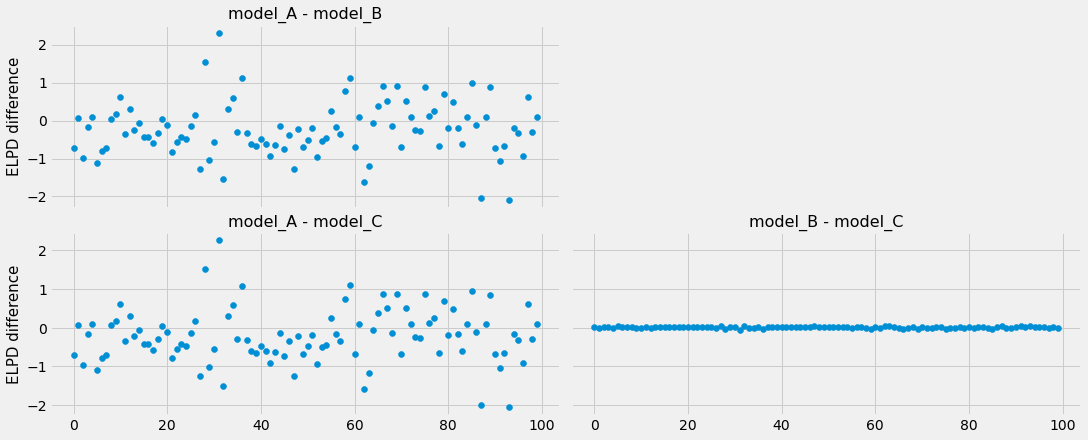

In [52]:
az.plot_elpd(inference_datas, figsize=(15, 6), textsize=14)
plt.show()

### Pareto shape parameter $\hat{\kappa}$

Approximation of $ELPD$ involves computing a Pareto distribution. Parameter $\hat{\kappa}$ of this distribution can be used to detect highly influencial observations.

$\hat{\kappa} > .7$ might indicate problems in the model, this should result in `warning` when calling `az.loo()` or `az.compare()`

We can also plot $\hat{\kappa}$s:

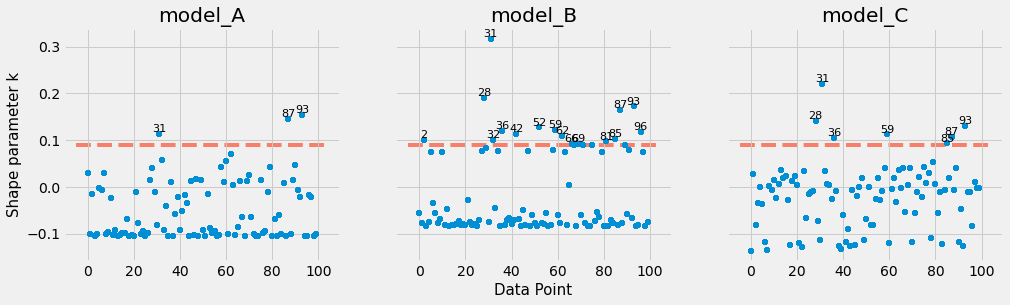

In [56]:
_, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

for idx, (model, ax) in enumerate(zip(('model_A', 'model_B', 'model_C'), axes)):
    
    loo_ = az.loo(inference_datas[model], pointwise=True)
    
    az.plot_khat(loo_, ax=ax, threshold=0.09, show_hlines=True, hlines_kwargs={"hlines":0.09, "ls":"--"})
    ax.set_title(model)
    
    if idx:
        axes[idx].set_ylabel('')
        
    if not idx % 2:
        axes[idx].set_xlabel('')

In this plot the threshold ($.09$) is completely arbitrary.